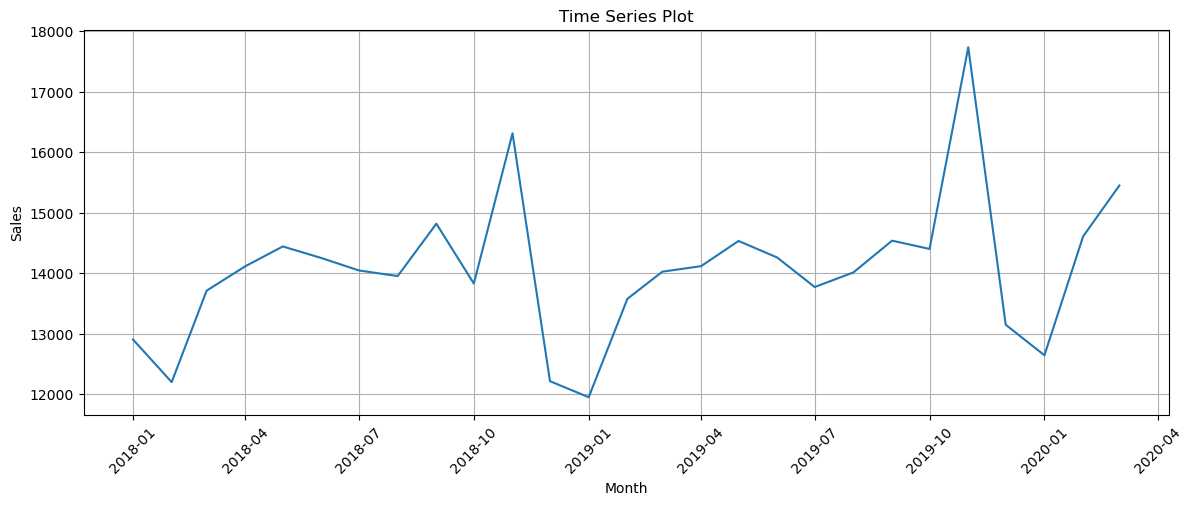

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX # Use SARIMAX for SARIMA
from statsmodels.tsa.stattools import adfuller  
from sklearn.model_selection import train_test_split

# Step 1: Read the data and data cleaning
df = pd.read_csv("quiz.csv")

# Data cleaning since both columns have object dtype. We set month column by datetime object and Sales to float.
df['Month'] = pd.to_datetime(df['Month'].str.strip(), format='%b-%y')
df['Sales'] = pd.to_numeric(df['Sales'].astype(str).str.replace(',', ''))

# Set 'Month' column as the index for plots
df.set_index('Month', inplace=True)

# Plot the time series
plt.figure(figsize=(14, 5))
sns.lineplot(x=df.index, y=df.iloc[:, 0])  # Assume the first column after 'Month' contains data Here, iloc[;,0]
#means that we select all rows and the first column of the DataFrame

# Formatting the plot
plt.xlabel('Month')
plt.ylabel('Sales')  # Change 'Value' to the actual column name
plt.title('Time Series Plot')
plt.xticks(rotation=45)
plt.grid()

# Show the plot
plt.show()


In [3]:
df

,Sales
Month,
2018-01-01,12903
2018-02-01,12198
2018-03-01,13711
2018-04-01,14115
2018-05-01,14442
2018-06-01,14250
2018-07-01,14045
2018-08-01,13952
2018-09-01,14819


The initial exploration of this time series data is the cyclical pattern which looks very likely to be seasonal.
<br> We can see that the sales peaks up in November, drops dramatically in December and hits lowest in January on yearly basis and increases during spring season.

In [4]:
# Step 2: Check for stationarity (ADF test) We write a function adf_test to take d fuller test whether this
#time series is Stationary
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("Data is non-stationary")
    else:
        print("Data is stationary")



# Apply ADF test to 'Sales' column.
adf_test(df['Sales'])


ADF Statistic: -4.554567065523646
p-value: 0.0001565056257483909
Data is stationary


 Since this data is stationary, no differencing is needed even though the graph indicates seasonal pattern.
<br> Also, the p-value for this ADF test is lower than 0.05 which means it is significant that this data is stationary.

/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


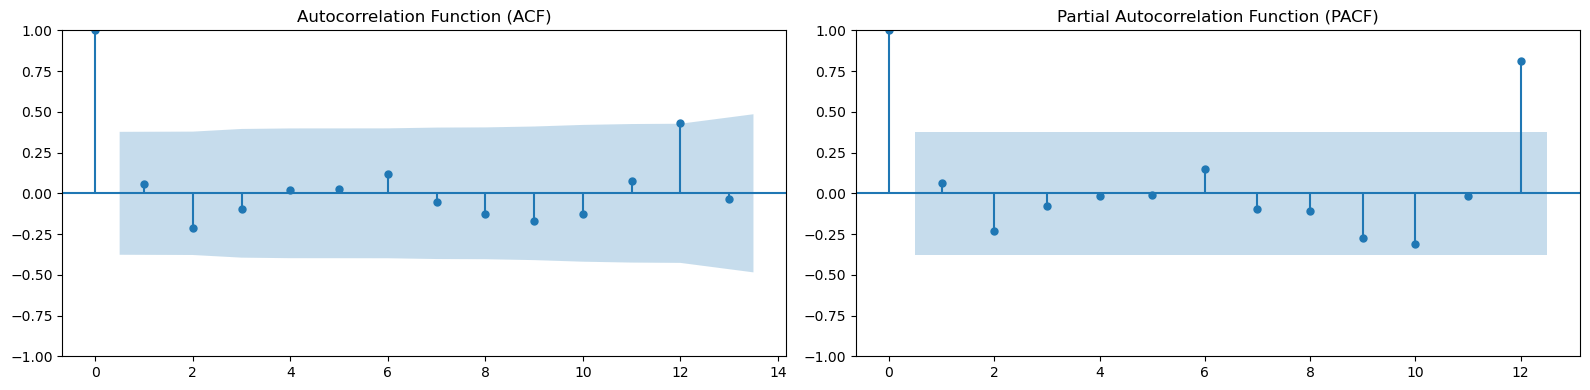

In [5]:
# We now want to Plot ACF and PACF for the series in order to identify the parameters
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(df['Sales'].dropna(), lags=13, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(df['Sales'].dropna(), lags=12, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

Here, the ACF plot shows strong spike on 12 in which our month would be November.

In [6]:
# Step 3: Fit the SARIMA model
# In SARIMA, you need to define the non-seasonal (p, d, q) and seasonal (P, D, Q, s) order
# (p, d, q) -> AR(autoregression), I(Integration), MA(Moving Average) terms for the non-seasonal component
# (P, D, Q, s) -> Seasonal AR, I, MA terms and the period (s) for the seasonality (e.g., 12 for monthly data)
# We will use grid search technique to find the combination that fits SARIMA model the best.

#First, we assign possible values for p, d, q and P, D, Q
p = d = q = range(0, 3)  
P = D = Q = range(0, 2) 
s = 12  # Seasonal period (12 for monthly data)

# Generate all possible combinations of (p, d, q) and (P, D, Q)
param_combinations = list(itertools.product(p, d, q, P, D, Q))

best_aic = float("inf")
best_params = None
best_model = None

# Grid Search to find optimal combination of parameters we use for loops
for params in param_combinations:
    try:
        # Unpack parameters and then fit SARIMA model
        p, d, q, P, D, Q = params
        
        model = SARIMAX(df['Sales'], 
                        order=(p, d, q), 
                        seasonal_order=(P, D, Q, s),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        results = model.fit(disp=False)
        
        # Check if the new model has a lower AIC
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = params
            best_model = results
            
        print(f'Tested SARIMA{params} - AIC: {results.aic}')
    
    except Exception as e:
        print(f'Error with SARIMA{params}: {e}')

# Print the best model parameters
print(f"\nBest SARIMA Model: {best_params} with AIC: {best_aic}")

# Print the model summary
print(best_model.summary())

/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: To

Tested SARIMA(0, 0, 0, 0, 0, 0) - AIC: 572.7817496519804
Tested SARIMA(0, 0, 0, 0, 0, 1) - AIC: 352.73910881555406
Tested SARIMA(0, 0, 0, 0, 1, 0) - AIC: 228.91707085632993
Tested SARIMA(0, 0, 0, 0, 1, 1) - AIC: 38.100532341114544
Tested SARIMA(0, 0, 0, 1, 0, 0) - AIC: 242.74059881888266


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda

Tested SARIMA(0, 0, 0, 1, 0, 1) - AIC: 232.51865819754084
Tested SARIMA(0, 0, 0, 1, 1, 0) - AIC: 54.03684592634471
Tested SARIMA(0, 0, 0, 1, 1, 1) - AIC: 34.38487695788563


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: To

Tested SARIMA(0, 0, 1, 0, 0, 0) - AIC: 535.5873431295579
Tested SARIMA(0, 0, 1, 0, 0, 1) - AIC: 279.62638759103146
Tested SARIMA(0, 0, 1, 0, 1, 0) - AIC: 207.2798212938203
Tested SARIMA(0, 0, 1, 0, 1, 1) - AIC: 21.859577777205274
Tested SARIMA(0, 0, 1, 1, 0, 0) - AIC: 320.5455645992686
Tested SARIMA(0, 0, 1, 1, 0, 1) - AIC: 198.84289841458124
Tested SARIMA(0, 0, 1, 1, 1, 0) - AIC: 52.97023512143213


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: To

Tested SARIMA(0, 0, 1, 1, 1, 1) - AIC: 22.90402530442456
Tested SARIMA(0, 0, 2, 0, 0, 0) - AIC: 483.8825681496461
Tested SARIMA(0, 0, 2, 0, 0, 1) - AIC: 230.52638732821626
Tested SARIMA(0, 0, 2, 0, 1, 0) - AIC: 189.9518461945586
Tested SARIMA(0, 0, 2, 0, 1, 1) - AIC: 8.0
Tested SARIMA(0, 0, 2, 1, 0, 0) - AIC: 322.5129438809216


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: To

Tested SARIMA(0, 0, 2, 1, 0, 1) - AIC: 221.19536500449973
Tested SARIMA(0, 0, 2, 1, 1, 0) - AIC: 52.740394766915486


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packa

Tested SARIMA(0, 0, 2, 1, 1, 1) - AIC: 10.0
Tested SARIMA(0, 1, 0, 0, 0, 0) - AIC: 443.422010504259
Tested SARIMA(0, 1, 0, 0, 0, 1) - AIC: 220.00717039228545
Tested SARIMA(0, 1, 0, 0, 1, 0) - AIC: 201.7027903002256
Tested SARIMA(0, 1, 0, 0, 1, 1) - AIC: -0.5638271141534439
Tested SARIMA(0, 1, 0, 1, 0, 0) - AIC: 230.97492881631484
Tested SARIMA(0, 1, 0, 1, 0, 1) - AIC: 205.12600929658063
Tested SARIMA(0, 1, 0, 1, 1, 0) - AIC: 33.126448785609945


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: To

Tested SARIMA(0, 1, 0, 1, 1, 1) - AIC: -0.8240129984489162
Tested SARIMA(0, 1, 1, 0, 0, 0) - AIC: 416.36147285698075
Tested SARIMA(0, 1, 1, 0, 0, 1) - AIC: 201.70126940169266
Tested SARIMA(0, 1, 1, 0, 1, 0) - AIC: 184.34490373316606
Tested SARIMA(0, 1, 1, 0, 1, 1) - AIC: 6.0


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was pr

Tested SARIMA(0, 1, 1, 1, 0, 0) - AIC: 222.83333989756875
Tested SARIMA(0, 1, 1, 1, 0, 1) - AIC: 185.59583464244201


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: To

Tested SARIMA(0, 1, 1, 1, 1, 0) - AIC: 32.69023003697049
Tested SARIMA(0, 1, 1, 1, 1, 1) - AIC: 8.0
Tested SARIMA(0, 1, 2, 0, 0, 0) - AIC: 400.600560834791
Tested SARIMA(0, 1, 2, 0, 0, 1) - AIC: 187.5761536378033


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: To

Tested SARIMA(0, 1, 2, 0, 1, 0) - AIC: 171.28576072813283
Tested SARIMA(0, 1, 2, 0, 1, 1) - AIC: 8.0
Tested SARIMA(0, 1, 2, 1, 0, 0) - AIC: 220.87225787776225


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ch

Tested SARIMA(0, 1, 2, 1, 0, 1) - AIC: 171.69135487525728


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ch

Tested SARIMA(0, 1, 2, 1, 1, 0) - AIC: 29.518271402561822
Tested SARIMA(0, 1, 2, 1, 1, 1) - AIC: 10.0
Tested SARIMA(0, 2, 0, 0, 0, 0) - AIC: 450.2869594815427
Tested SARIMA(0, 2, 0, 0, 0, 1) - AIC: 207.1188217744569
Tested SARIMA(0, 2, 0, 0, 1, 0) - AIC: 191.9424637670726
Tested SARIMA(0, 2, 0, 0, 1, 1) - AIC: 4.0


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was pr

Tested SARIMA(0, 2, 0, 1, 0, 0) - AIC: 223.82623137664677
Tested SARIMA(0, 2, 0, 1, 0, 1) - AIC: 194.26781059895228


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ch

Tested SARIMA(0, 2, 0, 1, 1, 0) - AIC: -0.2704067940598094
Tested SARIMA(0, 2, 0, 1, 1, 1) - AIC: 6.0
Tested SARIMA(0, 2, 1, 0, 0, 0) - AIC: 424.0147869297681
Tested SARIMA(0, 2, 1, 0, 0, 1) - AIC: 188.30947388156633
Tested SARIMA(0, 2, 1, 0, 1, 0) - AIC: 173.6427055568277
Tested SARIMA(0, 2, 1, 0, 1, 1) - AIC: 6.0
Tested SARIMA(0, 2, 1, 1, 0, 0) - AIC: 206.58430151984905


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda

Tested SARIMA(0, 2, 1, 1, 0, 1) - AIC: 171.65681720585823


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: 

Tested SARIMA(0, 2, 1, 1, 1, 0) - AIC: 10.058620475234118
Tested SARIMA(0, 2, 1, 1, 1, 1) - AIC: 8.0
Tested SARIMA(0, 2, 2, 0, 0, 0) - AIC: 391.09746367627764
Tested SARIMA(0, 2, 2, 0, 0, 1) - AIC: 171.72302376918174
Tested SARIMA(0, 2, 2, 0, 1, 0) - AIC: 160.352127993899
Tested SARIMA(0, 2, 2, 0, 1, 1) - AIC: 8.0


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: To

Tested SARIMA(0, 2, 2, 1, 0, 0) - AIC: 203.53863722392103
Tested SARIMA(0, 2, 2, 1, 0, 1) - AIC: 162.90975045843678


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ch

Tested SARIMA(0, 2, 2, 1, 1, 0) - AIC: 18.49672426945127
Tested SARIMA(0, 2, 2, 1, 1, 1) - AIC: 10.0
Tested SARIMA(1, 0, 0, 0, 0, 0) - AIC: 462.2475693715029
Tested SARIMA(1, 0, 0, 0, 0, 1) - AIC: 245.51060579743387
Tested SARIMA(1, 0, 0, 0, 1, 0) - AIC: 227.50356363133153


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: 

Tested SARIMA(1, 0, 0, 0, 1, 1) - AIC: 9.940824764591792
Tested SARIMA(1, 0, 0, 1, 0, 0) - AIC: 240.61802892168052


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Tested SARIMA(1, 0, 0, 1, 0, 1) - AIC: 223.97922848809927
Tested SARIMA(1, 0, 0, 1, 1, 0) - AIC: -9.425126827197744


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ch

Tested SARIMA(1, 0, 0, 1, 1, 1) - AIC: 19.682512279597464
Tested SARIMA(1, 0, 1, 0, 0, 0) - AIC: 435.0978403333801
Tested SARIMA(1, 0, 1, 0, 0, 1) - AIC: 226.82610342447003
Tested SARIMA(1, 0, 1, 0, 1, 0) - AIC: 203.67095175567707


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(1, 0, 1, 0, 1, 1) - AIC: 20.147947328293853
Tested SARIMA(1, 0, 1, 1, 0, 0) - AIC: 223.49828586573352


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ch

Tested SARIMA(1, 0, 1, 1, 0, 1) - AIC: 217.70301076622547


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Tested SARIMA(1, 0, 1, 1, 1, 0) - AIC: 32.31152881412645


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: 

Tested SARIMA(1, 0, 1, 1, 1, 1) - AIC: 21.66042544981846
Tested SARIMA(1, 0, 2, 0, 0, 0) - AIC: 418.8783348593254
Tested SARIMA(1, 0, 2, 0, 0, 1) - AIC: 210.71383590817072


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: To

Tested SARIMA(1, 0, 2, 0, 1, 0) - AIC: 187.45069877165466
Tested SARIMA(1, 0, 2, 0, 1, 1) - AIC: 10.0


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Tested SARIMA(1, 0, 2, 1, 0, 0) - AIC: 233.09781978849398


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Tested SARIMA(1, 0, 2, 1, 0, 1) - AIC: 202.87389915896705


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ch

Tested SARIMA(1, 0, 2, 1, 1, 0) - AIC: 38.444792750968894
Tested SARIMA(1, 0, 2, 1, 1, 1) - AIC: 12.0
Tested SARIMA(1, 1, 0, 0, 0, 0) - AIC: 441.70666437577717
Tested SARIMA(1, 1, 0, 0, 0, 1) - AIC: 221.97204771410514
Tested SARIMA(1, 1, 0, 0, 1, 0) - AIC: 201.58320627949635


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Tested SARIMA(1, 1, 0, 0, 1, 1) - AIC: 11.940922897838057
Tested SARIMA(1, 1, 0, 1, 0, 0) - AIC: 202.1587490795414
Tested SARIMA(1, 1, 0, 1, 0, 1) - AIC: 204.1563766663646


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: To

Tested SARIMA(1, 1, 0, 1, 1, 0) - AIC: 12.59172291441519


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Tested SARIMA(1, 1, 0, 1, 1, 1) - AIC: 15.894162938034409
Tested SARIMA(1, 1, 1, 0, 0, 0) - AIC: 417.48840996568555
Tested SARIMA(1, 1, 1, 0, 0, 1) - AIC: 202.14317928496246


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: To

Tested SARIMA(1, 1, 1, 0, 1, 0) - AIC: 185.95442288744692
Tested SARIMA(1, 1, 1, 0, 1, 1) - AIC: 8.0
Tested SARIMA(1, 1, 1, 1, 0, 0) - AIC: 201.5055616415285


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packa

Tested SARIMA(1, 1, 1, 1, 0, 1) - AIC: 187.55584528869088


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: 

Tested SARIMA(1, 1, 1, 1, 1, 0) - AIC: 15.76559312327441
Tested SARIMA(1, 1, 1, 1, 1, 1) - AIC: 10.0
Tested SARIMA(1, 1, 2, 0, 0, 0) - AIC: 401.69496817843105
Tested SARIMA(1, 1, 2, 0, 0, 1) - AIC: 188.54696218264692
Tested SARIMA(1, 1, 2, 0, 1, 0) - AIC: 173.24811903054837
Tested SARIMA(1, 1, 2, 0, 1, 1) - AIC: 10.0


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: To

Tested SARIMA(1, 1, 2, 1, 0, 0) - AIC: 203.74035139285178


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ch

Tested SARIMA(1, 1, 2, 1, 0, 1) - AIC: 173.19129886672508


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ch

Tested SARIMA(1, 1, 2, 1, 1, 0) - AIC: 16.27656553946386
Tested SARIMA(1, 1, 2, 1, 1, 1) - AIC: 12.0
Tested SARIMA(1, 2, 0, 0, 0, 0) - AIC: 442.00188120405807
Tested SARIMA(1, 2, 0, 0, 0, 1) - AIC: 207.53633433342245
Tested SARIMA(1, 2, 0, 0, 1, 0) - AIC: 191.81330711534667


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was pr

Tested SARIMA(1, 2, 0, 0, 1, 1) - AIC: 6.0
Tested SARIMA(1, 2, 0, 1, 0, 0) - AIC: 190.5641517212247
Tested SARIMA(1, 2, 0, 1, 0, 1) - AIC: 192.54522659920073
Tested SARIMA(1, 2, 0, 1, 1, 0) - AIC: 6.0
Tested SARIMA(1, 2, 0, 1, 1, 1) - AIC: 8.0
Tested SARIMA(1, 2, 1, 0, 0, 0) - AIC: 419.80484812013617


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was pr

Tested SARIMA(1, 2, 1, 0, 0, 1) - AIC: 188.97996234522122
Tested SARIMA(1, 2, 1, 0, 1, 0) - AIC: 175.64168189249378
Tested SARIMA(1, 2, 1, 0, 1, 1) - AIC: 8.0


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: To

Tested SARIMA(1, 2, 1, 1, 0, 0) - AIC: 187.29795539257375
Tested SARIMA(1, 2, 1, 1, 0, 1) - AIC: 173.65672067095397
Tested SARIMA(1, 2, 1, 1, 1, 0) - AIC: 8.0


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda

Tested SARIMA(1, 2, 1, 1, 1, 1) - AIC: 10.0
Tested SARIMA(1, 2, 2, 0, 0, 0) - AIC: 391.90260169727065
Tested SARIMA(1, 2, 2, 0, 0, 1) - AIC: 173.71048687203853
Tested SARIMA(1, 2, 2, 0, 1, 0) - AIC: 162.32531711954033
Tested SARIMA(1, 2, 2, 0, 1, 1) - AIC: 10.0


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: To

Tested SARIMA(1, 2, 2, 1, 0, 0) - AIC: 189.3039136562634


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency

Tested SARIMA(1, 2, 2, 1, 0, 1) - AIC: 163.82894967132253
Tested SARIMA(1, 2, 2, 1, 1, 0) - AIC: 10.0
Tested SARIMA(1, 2, 2, 1, 1, 1) - AIC: 12.0
Tested SARIMA(2, 0, 0, 0, 0, 0) - AIC: 443.6166246202434
Tested SARIMA(2, 0, 0, 0, 0, 1) - AIC: 240.54398580985446
Tested SARIMA(2, 0, 0, 0, 1, 0) - AIC: 203.23544962681413


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: 

Tested SARIMA(2, 0, 0, 0, 1, 1) - AIC: 36.16178340217931
Tested SARIMA(2, 0, 0, 1, 0, 0) - AIC: 203.64599150130178


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Tested SARIMA(2, 0, 0, 1, 0, 1) - AIC: 204.48784422755043
Tested SARIMA(2, 0, 0, 1, 1, 0) - AIC: 0.4941697595141532


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Tested SARIMA(2, 0, 0, 1, 1, 1) - AIC: 23.99851424304774
Tested SARIMA(2, 0, 1, 0, 0, 0) - AIC: 435.7773448807663
Tested SARIMA(2, 0, 1, 0, 0, 1) - AIC: 228.45885555571965


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: To

Tested SARIMA(2, 0, 1, 0, 1, 0) - AIC: 204.4464357145651


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ch

Tested SARIMA(2, 0, 1, 0, 1, 1) - AIC: 11.30578832828453


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Tested SARIMA(2, 0, 1, 1, 0, 0) - AIC: 204.8799666977076


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Tested SARIMA(2, 0, 1, 1, 0, 1) - AIC: 225.36981187553786


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Tested SARIMA(2, 0, 1, 1, 1, 0) - AIC: 23.99535783237456


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: 

Tested SARIMA(2, 0, 1, 1, 1, 1) - AIC: 25.996353240765885
Tested SARIMA(2, 0, 2, 0, 0, 0) - AIC: 420.53111178414645


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: 

Tested SARIMA(2, 0, 2, 0, 0, 1) - AIC: 212.52723641018144
Tested SARIMA(2, 0, 2, 0, 1, 0) - AIC: 189.44993138587233
Tested SARIMA(2, 0, 2, 0, 1, 1) - AIC: 12.0


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Tested SARIMA(2, 0, 2, 1, 0, 0) - AIC: 224.41796311055276


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Tested SARIMA(2, 0, 2, 1, 0, 1) - AIC: 210.09730028590994


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ch

Tested SARIMA(2, 0, 2, 1, 1, 0) - AIC: 25.8578921571765
Tested SARIMA(2, 0, 2, 1, 1, 1) - AIC: 14.0
Tested SARIMA(2, 1, 0, 0, 0, 0) - AIC: 423.181817580814
Tested SARIMA(2, 1, 0, 0, 0, 1) - AIC: 223.968295917633
Tested SARIMA(2, 1, 0, 0, 1, 0) - AIC: 185.06592453711187


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ch

Tested SARIMA(2, 1, 0, 0, 1, 1) - AIC: 21.876117446944455
Tested SARIMA(2, 1, 0, 1, 0, 0) - AIC: 185.42877150147606
Tested SARIMA(2, 1, 0, 1, 0, 1) - AIC: 186.98570237390166
Tested SARIMA(2, 1, 0, 1, 1, 0) - AIC: 8.0
Tested SARIMA(2, 1, 0, 1, 1, 1) - AIC: 10.0
Tested SARIMA(2, 1, 1, 0, 0, 0) - AIC: 419.42446536130535


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was pr

Tested SARIMA(2, 1, 1, 0, 0, 1) - AIC: 203.11257097275765
Tested SARIMA(2, 1, 1, 0, 1, 0) - AIC: 187.0434557800458
Tested SARIMA(2, 1, 1, 0, 1, 1) - AIC: 10.0


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: To

Tested SARIMA(2, 1, 1, 1, 0, 0) - AIC: 187.41769375020382


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency

Tested SARIMA(2, 1, 1, 1, 0, 1) - AIC: 189.02822309691203
Tested SARIMA(2, 1, 1, 1, 1, 0) - AIC: 10.0
Tested SARIMA(2, 1, 1, 1, 1, 1) - AIC: 12.0
Tested SARIMA(2, 1, 2, 0, 0, 0) - AIC: 403.6086747453565


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: 

Tested SARIMA(2, 1, 2, 0, 0, 1) - AIC: 190.08839212304858
Tested SARIMA(2, 1, 2, 0, 1, 0) - AIC: 174.90760484175686
Tested SARIMA(2, 1, 2, 0, 1, 1) - AIC: 12.0


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Tested SARIMA(2, 1, 2, 1, 0, 0) - AIC: 187.37906949773316


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency

Tested SARIMA(2, 1, 2, 1, 0, 1) - AIC: 178.0045821459496
Tested SARIMA(2, 1, 2, 1, 1, 0) - AIC: 12.0
Tested SARIMA(2, 1, 2, 1, 1, 1) - AIC: 14.0
Tested SARIMA(2, 2, 0, 0, 0, 0) - AIC: 420.94189187428043
Tested SARIMA(2, 2, 0, 0, 0, 1) - AIC: 208.3333043790178
Tested SARIMA(2, 2, 0, 0, 1, 0) - AIC: 175.56781079060727
Tested SARIMA(2, 2, 0, 0, 1, 1) - AIC: 8.0
Tested SARIMA(2, 2, 0, 1, 0, 0) - AIC: 175.0763171016142


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: To

Tested SARIMA(2, 2, 0, 1, 0, 1) - AIC: 174.99345776504444
Tested SARIMA(2, 2, 0, 1, 1, 0) - AIC: 8.0
Tested SARIMA(2, 2, 0, 1, 1, 1) - AIC: 10.0
Tested SARIMA(2, 2, 1, 0, 0, 0) - AIC: 420.12506278612
Tested SARIMA(2, 2, 1, 0, 0, 1) - AIC: 190.3353101008186


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: To

Tested SARIMA(2, 2, 1, 0, 1, 0) - AIC: 174.63427295908997
Tested SARIMA(2, 2, 1, 0, 1, 1) - AIC: 10.0
Tested SARIMA(2, 2, 1, 1, 0, 0) - AIC: 172.8447469053063


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda

Tested SARIMA(2, 2, 1, 1, 0, 1) - AIC: 174.60862519808504
Tested SARIMA(2, 2, 1, 1, 1, 0) - AIC: 10.0
Tested SARIMA(2, 2, 1, 1, 1, 1) - AIC: 12.0
Tested SARIMA(2, 2, 2, 0, 0, 0) - AIC: 393.11898699491326
Tested SARIMA(2, 2, 2, 0, 0, 1) - AIC: 175.69065671365956
Tested SARIMA(2, 2, 2, 0, 1, 0) - AIC: 162.10373817851402
Tested SARIMA(2, 2, 2, 0, 1, 1) - AIC: 12.0


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: To

Tested SARIMA(2, 2, 2, 1, 0, 0) - AIC: 175.06571106138097
Tested SARIMA(2, 2, 2, 1, 0, 1) - AIC: 171.4488726538821
Tested SARIMA(2, 2, 2, 1, 1, 0) - AIC: 12.0
Tested SARIMA(2, 2, 2, 1, 1, 1) - AIC: 14.0

Best SARIMA Model: (1, 0, 0, 1, 1, 0) with AIC: -9.425126827197744
                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   27
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                   7.713
Date:                            Fri, 25 Apr 2025   AIC                             -9.425
Time:                                    15:42:06   BIC                            -13.346
Sample:                                01-01-2018   HQIC                           -17.624
                                     - 03-01-2020                                         
Covariance Type:                              opg                                         
 

/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: 

We have figured out that non-seasonal parameter (p,d,q) is (1, 0, 0) and seasonal parameter (P, D, Q) is (1, 1, 0).
<br>Log-likelihood has the highest value of 7.713, higher the better,
and AIC is -9.425 which means lower the better.

/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


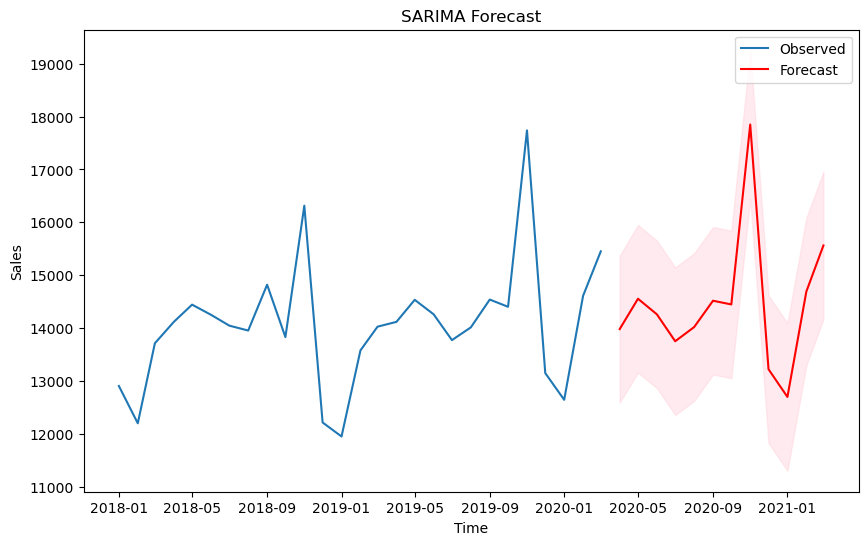

Forecasted Sales:
2020-04-01    13978.951219
2020-05-01    14553.523992
2020-06-01    14258.387359
2020-07-01    13749.757847
2020-08-01    14016.667149
2020-09-01    14516.084394
2020-10-01    14445.691513
2020-11-01    17849.066131
2020-12-01    13219.848142
2021-01-01    12696.129134
2021-02-01    14689.569734
2021-03-01    15561.144115
Freq: MS, Name: predicted_mean, dtype: float64


In [8]:
# Now we set the parameters for best fit for SARIMA:
p, d, q = 1, 0, 0  # Non-seasonal
P, D, Q, s = 1, 1, 0, 12  # Seasonal and period (12 for monthly data)

# Fit the SARIMA model
sarima_model = SARIMAX(df['Sales'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_result = sarima_model.fit(disp=False)

# Step 4: Forecast future values (e.g., next 12 months)
forecast_steps = 12  # Number of periods to forecast (adjust based on your needs)
forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Step 5: Plot the results and print forecasted value for next year Mar 2021
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Sales'], label='Observed')
plt.plot(forecast_mean.index, forecast_mean, color='red', label='Forecast')
plt.fill_between(forecast_mean.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

print("Forecasted Sales:")
print(forecast_mean)

In [9]:
print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   27
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                -120.835
Date:                            Fri, 25 Apr 2025   AIC                            247.670
Time:                                    15:43:11   BIC                            249.794
Sample:                                01-01-2018   HQIC                           247.648
                                     - 03-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0979      0.144     -0.681      0.496      -0.380       0.184
ar.S.L12       0.0780      0.070   

Here we see both p-values higher than 0.05 and this indicates that AR(p) is not statistically significant which means that the past Sales in previous month is correlated to the current month of sales. 
<br> Also, p-value Seasonal AR(P) indicates not significant so previous sales does not accordingly
corelate to next month sales with seasonality.

In [10]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Best SARIMA parameters from grid search
p, d, q = 1, 0, 0
P, D, Q, s = 1, 1, 0, 12

# Fit SARIMA model on training set
sarima_model = SARIMAX(train['Sales'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_result = sarima_model.fit(disp=False)

# Forecast for the test period
forecast = sarima_result.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test['Sales'], forecast_mean))
print(f'RMSE: {rmse:.2f}')

RMSE: 1005.43


/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chriskim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Here, we calculate RMSE(Rooted mean square) and this combination of p, d, q gives the lowest value.